# Thermal Impedance to SPICE-model
## How to read data sheet
The example DIODE used is SM6TY
![alt text](Example_Diode_Thermal_Impedance.png "Title")


## import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## The serie of thermal impedance exponentials

In [2]:
def model_function(t, Ri, Ti):
    return np.multiply(Ri, (1-np.exp(np.multiply(t*-1,Ti))))

def model_series(t, R1, T1, R2, T2, R3, T3, R4, T4, R5, T5, R6, T6):
    return  model_function(t, R1, T1) + model_function(t, R2, T2) + model_function(t, R3, T3) + model_function(t, R4, T4) + model_function(t, R5, T5) + model_function(t, R6, T6)

## Input data here like the blue dots in the graph above

In [3]:
# look up deephaven input_table: https://deephaven.io/core/docs/how-to-guides/input-tables/
x_data = [1e-2,2e-2,5e-2,1e-1,5e-1,1e0,5e0,1e1,2e1,5e1,1e2,5e2,1e3]
y_data = [3.5e0,4e0,5.5e0,7e0,1.5e1,2.3e1,5.5e1,6.5e1,8.3e1,1.1e2,1.3e2,1.5e2,1.5e2]

print("This is your x data")
print(x_data)
print("this is your y data")
print(y_data)

This is your x data
[0.01, 0.02, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0, 50.0, 100.0, 500.0, 1000.0]
this is your y data
[3.5, 4.0, 5.5, 7.0, 15.0, 23.0, 55.0, 65.0, 83.0, 110.0, 130.0, 150.0, 150.0]


## If the thermal curve is only relative the thermal resistance provided in data sheet
Provide the thermal resistance or if not set it to 99999

In [5]:
Rth = 99999

## Set the axes of your plot to the same as the plot in the datasheet
In the graph above its xlim 

set is_square_plot = True if your plot is square and False if it's not

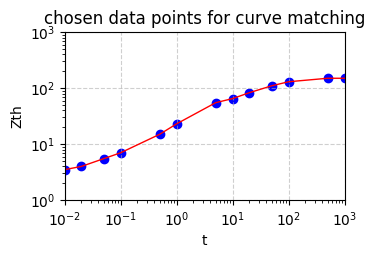

In [6]:
graph_scale_base = 10

time_scale_lowest_exponent = -2
time_scale_highest_exponent = 3

thermal_impedance_lowest_exponent = 0
thermal_impedance_highest_exponent = 3

is_square_plot = True

t_lower_limit = graph_scale_base**time_scale_lowest_exponent
t_upper_limit = graph_scale_base**time_scale_highest_exponent
z_lower_limit = graph_scale_base**thermal_impedance_lowest_exponent
z_upper_limit = graph_scale_base**thermal_impedance_highest_exponent

# expand the amount of points in time(logarithmically spaced) for more elaborate graphs
x_data_expanded = np.logspace(time_scale_lowest_exponent, time_scale_highest_exponent, num=1000, base=graph_scale_base)

# create figure and initiate subplot
fig = plt.figure()
ax = fig.add_subplot(2,1,1)

# plot data
line = ax.scatter(x_data, y_data, label='Data', color='blue', lw=1)
line = ax.plot(x_data, y_data, label='Data', color='red', lw=1)

# set labels
ax.set_xlabel('t')
ax.set_ylabel('Zth')
ax.set_title('chosen data points for curve matching')

if is_square_plot:
    ax.set_aspect('equal', adjustable='box')

# set limits
plt.xlim([t_lower_limit, t_upper_limit])
plt.ylim([z_lower_limit, z_upper_limit])

# set to logarithmic scales
ax.set_xscale('log')
ax.set_yscale('log')

# set grid lines
ax.grid(True, linestyle='--', alpha=0.6)

## Make an initial guess for the parameters resistance Ri and timeconstant Ti

The function is displayed logarithmically and that since it makes most sense
we distribute the R values logarithmically between the first value and the end value

In [7]:
n = 6
datapoint_breakpoint = 12

# distributes y-data
distribution = np.empty(n)
val_max = y_data[12]
val_min = y_data[0]

for i in range(n):
    distribution[i] = val_min * np.power((val_max/val_min), (i/(n-1)) )

normalized_distribution = np.empty_like(distribution)

for i in range(n):
    normalized_distribution[i] = distribution[i] * val_max / np.sum(distribution)

#distributes x-data
distribution_x = np.empty(n)
val_max_x = x_data[datapoint_breakpoint-1]
val_min_x = x_data[0]

for i in range(n):
    distribution_x[i] = val_min_x * np.power((val_max_x/val_min_x), (i/(n-1)) )

normalized_distribution_x = np.empty_like(distribution_x)

for i in range(n):
    normalized_distribution_x[i] = distribution_x[i] * val_max_x / np.sum(distribution_x)

initial_guess = [ normalized_distribution[0] , normalized_distribution_x[5]\
                 ,normalized_distribution[1] , normalized_distribution_x[4]\
                 ,normalized_distribution[2] , normalized_distribution_x[3]\
                 ,normalized_distribution[3] , normalized_distribution_x[2]\
                 ,normalized_distribution[4] , normalized_distribution_x[1]\
                 ,normalized_distribution[5] , normalized_distribution_x[0]]
print(initial_guess)

[np.float64(1.8698954041696316), np.float64(442.566099000048), np.float64(3.964806138984179), np.float64(50.83749498988103), np.float64(8.406720335626101), np.float64(5.83969468670463), np.float64(17.8250699590413), np.float64(0.6708047680302538), np.float64(37.795133697766), np.float64(0.07705523335605202), np.float64(80.13837446441278), np.float64(0.00885132198000096)]


## Plot the initial guesses

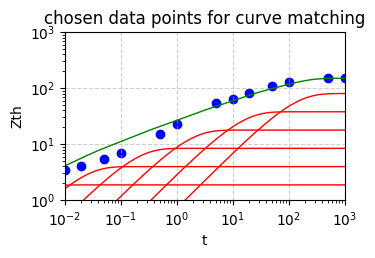

In [8]:
y_data_initial = np.empty_like(x_data_expanded)
y_data_initial_1 = np.empty_like(x_data_expanded)
y_data_initial_2 = np.empty_like(x_data_expanded)
y_data_initial_3 = np.empty_like(x_data_expanded)
y_data_initial_4 = np.empty_like(x_data_expanded)
y_data_initial_5 = np.empty_like(x_data_expanded)
y_data_initial_6 = np.empty_like(x_data_expanded)

for i in range(len(x_data_expanded)):
    y_data_initial[i] = model_series(x_data_expanded[i]\
                                     ,initial_guess[0], initial_guess[1]\
                                     ,initial_guess[2], initial_guess[3]\
                                     ,initial_guess[4], initial_guess[5]\
                                     ,initial_guess[6], initial_guess[7]\
                                     ,initial_guess[8], initial_guess[9]\
                                     ,initial_guess[10],initial_guess[11])
    y_data_initial_1[i] = model_function(x_data_expanded[i]\
                                         ,initial_guess[0], initial_guess[1])

    y_data_initial_2[i] = model_function(x_data_expanded[i]\
                                         ,initial_guess[2], initial_guess[3])

    y_data_initial_3[i] = model_function(x_data_expanded[i]\
                                         ,initial_guess[4], initial_guess[5])

    y_data_initial_4[i] = model_function(x_data_expanded[i]\
                                         ,initial_guess[6], initial_guess[7])
    
    y_data_initial_5[i] = model_function(x_data_expanded[i]\
                                         ,initial_guess[8], initial_guess[9])
    
    y_data_initial_6[i] = model_function(x_data_expanded[i]\
                                         ,initial_guess[10], initial_guess[11])

# create figure and initiate subplot
fig = plt.figure()
ax = fig.add_subplot(2,1,1)

# plot data
line = ax.plot(x_data_expanded, y_data_initial, label='Data', color='green', lw=1)
line = ax.plot(x_data_expanded, y_data_initial_1, label='Data', color='red', lw=1)
line = ax.plot(x_data_expanded, y_data_initial_2, label='Data', color='red', lw=1)
line = ax.plot(x_data_expanded, y_data_initial_3, label='Data', color='red', lw=1)
line = ax.plot(x_data_expanded, y_data_initial_4, label='Data', color='red', lw=1)
line = ax.plot(x_data_expanded, y_data_initial_5, label='Data', color='red', lw=1)
line = ax.plot(x_data_expanded, y_data_initial_6, label='Data', color='red', lw=1)
data = ax.scatter(x_data, y_data, label='Data', color='blue', lw=1)

# set labels
ax.set_xlabel('t')
ax.set_ylabel('Zth')
ax.set_title('chosen data points for curve matching')

if is_square_plot:
    ax.set_aspect('equal', adjustable='box')

# set limits
plt.xlim([t_lower_limit, t_upper_limit])
plt.ylim([z_lower_limit, z_upper_limit])

# set to logarithmic scales
ax.set_xscale('log')
ax.set_yscale('log')

# set grid lines
ax.grid(True, linestyle='--', alpha=0.6)


## Adjust guess

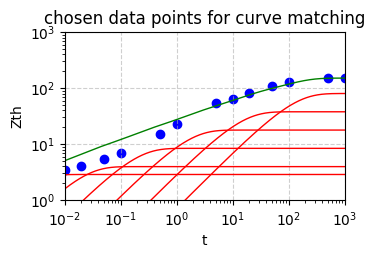

In [9]:
initial_guess[0] += 1

#bad = True
#furthest_off = 2
#amount = -2e0
#if bad:
#    initial_guess[(furthest_off-1)*2] = initial_guess[(furthest_off-1)*2] - amount/2

y_data_initial = np.empty_like(x_data_expanded)
y_data_initial_1 = np.empty_like(x_data_expanded)
y_data_initial_2 = np.empty_like(x_data_expanded)
y_data_initial_3 = np.empty_like(x_data_expanded)
y_data_initial_4 = np.empty_like(x_data_expanded)
y_data_initial_5 = np.empty_like(x_data_expanded)
y_data_initial_6 = np.empty_like(x_data_expanded)

for i in range(len(x_data_expanded)):
    y_data_initial[i] = model_series(x_data_expanded[i]\
                                     ,initial_guess[0], initial_guess[1]\
                                     ,initial_guess[2], initial_guess[3]\
                                     ,initial_guess[4], initial_guess[5]\
                                     ,initial_guess[6], initial_guess[7]\
                                     ,initial_guess[8], initial_guess[9]\
                                     ,initial_guess[10],initial_guess[11])
    y_data_initial_1[i] = model_function(x_data_expanded[i]\
                                         ,initial_guess[0], initial_guess[1])

    y_data_initial_2[i] = model_function(x_data_expanded[i]\
                                         ,initial_guess[2], initial_guess[3])

    y_data_initial_3[i] = model_function(x_data_expanded[i]\
                                         ,initial_guess[4], initial_guess[5])

    y_data_initial_4[i] = model_function(x_data_expanded[i]\
                                         ,initial_guess[6], initial_guess[7])
    
    y_data_initial_5[i] = model_function(x_data_expanded[i]\
                                         ,initial_guess[8], initial_guess[9])
    
    y_data_initial_6[i] = model_function(x_data_expanded[i]\
                                         ,initial_guess[10], initial_guess[11])

# create figure and initiate subplot
fig = plt.figure()
ax = fig.add_subplot(2,1,1)

# plot data
line = ax.plot(x_data_expanded, y_data_initial, label='Data', color='green', lw=1)
line = ax.plot(x_data_expanded, y_data_initial_1, label='Data', color='red', lw=1)
line = ax.plot(x_data_expanded, y_data_initial_2, label='Data', color='red', lw=1)
line = ax.plot(x_data_expanded, y_data_initial_3, label='Data', color='red', lw=1)
line = ax.plot(x_data_expanded, y_data_initial_4, label='Data', color='red', lw=1)
line = ax.plot(x_data_expanded, y_data_initial_5, label='Data', color='red', lw=1)
line = ax.plot(x_data_expanded, y_data_initial_6, label='Data', color='red', lw=1)
data = ax.scatter(x_data, y_data, label='Data', color='blue', lw=1)

# set labels
ax.set_xlabel('t')
ax.set_ylabel('Zth')
ax.set_title('chosen data points for curve matching')

if is_square_plot:
    ax.set_aspect('equal', adjustable='box')

# set limits
plt.xlim([t_lower_limit, t_upper_limit])
plt.ylim([z_lower_limit, z_upper_limit])

# set to logarithmic scales
ax.set_xscale('log')
ax.set_yscale('log')

# set grid lines
ax.grid(True, linestyle='--', alpha=0.6)


## Run curve fit

/tmp/ipykernel_83/4051863435.py:2: RuntimeWarning: overflow encountered in exp
  return np.multiply(Ri, (1-np.exp(np.multiply(t*-1,Ti))))


Initial guess:        R1 = 2.8698954041696316,                T1 = 442.566099000048
Optimized parameters: R1 = 2.4189373659565034, T1 = 1034.350323903152
Initial guess:        R2 = 3.964806138984179,                T2 = 50.83749498988103
Optimized parameters: R2 = 1.9341153089845189, T2 = 51.21480064880608
Initial guess:        R3 = 8.406720335626101,                T3 = 5.83969468670463
Optimized parameters: R3 = 9.57111504504735, T3 = 0.04002529217934117
Initial guess:        R4 = 17.8250699590413,                T4 = 0.6708047680302538
Optimized parameters: R4 = 40.93086342621274, T4 = 0.5273790773673156
Initial guess:        R5 = 37.795133697766,                T5 = 0.07705523335605202
Optimized parameters: R5 = 36.04601362200058, T5 = 0.04002511637526152
Initial guess:        R6 = 80.13837446441278,               T6 = 0.00885132198000096
Optimized parameters: R6 = 59.20581416937648, T6 = 0.011213714945537119


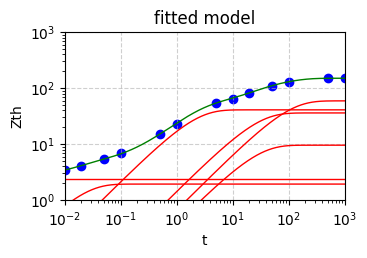

In [10]:
# Step 4: Use curve_fit to fit the model to the data
params, params_covariance = curve_fit(model_series, x_data, y_data, p0=initial_guess, method='lm')

# Step 5: Extract and print the optimized parameters
R1_opt, T1_opt, R2_opt, T2_opt, R3_opt, T3_opt, R4_opt, T4_opt, R5_opt, T5_opt, R6_opt, T6_opt = params
print(f"Initial guess:        R1 = {initial_guess[0]},                T1 = {initial_guess[1]}")
print(f"Optimized parameters: R1 = {R1_opt}, T1 = {T1_opt}")
print(f"Initial guess:        R2 = {initial_guess[2]},                T2 = {initial_guess[3]}")
print(f"Optimized parameters: R2 = {R2_opt}, T2 = {T2_opt}")
print(f"Initial guess:        R3 = {initial_guess[4]},                T3 = {initial_guess[5]}")
print(f"Optimized parameters: R3 = {R3_opt}, T3 = {T3_opt}")
print(f"Initial guess:        R4 = {initial_guess[6]},                T4 = {initial_guess[7]}")
print(f"Optimized parameters: R4 = {R4_opt}, T4 = {T4_opt}")
print(f"Initial guess:        R5 = {initial_guess[8]},                T5 = {initial_guess[9]}")
print(f"Optimized parameters: R5 = {R5_opt}, T5 = {T5_opt}")
print(f"Initial guess:        R6 = {initial_guess[10]},               T6 = {initial_guess[11]}")
print(f"Optimized parameters: R6 = {R6_opt}, T6 = {T6_opt}")

y_data_fitted = np.empty_like(x_data_expanded)
y_data_fitted_1 = np.empty_like(x_data_expanded)
y_data_fitted_2 = np.empty_like(x_data_expanded)
y_data_fitted_3 = np.empty_like(x_data_expanded)
y_data_fitted_4 = np.empty_like(x_data_expanded)
y_data_fitted_5 = np.empty_like(x_data_expanded)
y_data_fitted_6 = np.empty_like(x_data_expanded)

# Plot the data and the fitted curve
for i in range(len(x_data_expanded)):
    y_data_fitted[i] = model_series(x_data_expanded[i]\
                                     ,R1_opt, T1_opt\
                                     ,R2_opt, T2_opt\
                                     ,R3_opt, T3_opt\
                                     ,R4_opt, T4_opt\
                                     ,R5_opt, T5_opt\
                                     ,R6_opt, T6_opt)

    y_data_fitted_1[i] = model_function(x_data_expanded[i]\
                                         ,R1_opt, T1_opt)

    y_data_fitted_2[i] = model_function(x_data_expanded[i]\
                                         ,R2_opt, T2_opt)
    
    y_data_fitted_3[i] = model_function(x_data_expanded[i]\
                                         ,R3_opt, T3_opt)
    
    y_data_fitted_4[i] = model_function(x_data_expanded[i]\
                                         ,R4_opt, T4_opt)
    
    y_data_fitted_5[i] = model_function(x_data_expanded[i]\
                                         ,R5_opt, T5_opt)
    
    y_data_fitted_6[i] = model_function(x_data_expanded[i]\
                                         ,R6_opt, T6_opt)

# create figure and initiate subplot
fig = plt.figure()
ax = fig.add_subplot(2,1,1)

# plot data
line = ax.plot(x_data_expanded, y_data_fitted, label='Data', color='green', lw=1)
line = ax.plot(x_data_expanded, y_data_fitted_1, label='Data', color='red', lw=1)
line = ax.plot(x_data_expanded, y_data_fitted_2, label='Data', color='red', lw=1)
line = ax.plot(x_data_expanded, y_data_fitted_3, label='Data', color='red', lw=1)
line = ax.plot(x_data_expanded, y_data_fitted_4, label='Data', color='red', lw=1)
line = ax.plot(x_data_expanded, y_data_fitted_5, label='Data', color='red', lw=1)
line = ax.plot(x_data_expanded, y_data_fitted_6, label='Data', color='red', lw=1)
data = ax.scatter(x_data, y_data, label='Data', color='blue', lw=1)

# set labels
ax.set_xlabel('t')
ax.set_ylabel('Zth')
ax.set_title('fitted model')

if is_square_plot:
    ax.set_aspect('equal', adjustable='box')

# set limits
plt.xlim([t_lower_limit, t_upper_limit])
plt.ylim([z_lower_limit, z_upper_limit])

# set to logarithmic scales
ax.set_xscale('log')
ax.set_yscale('log')

# set grid lines
ax.grid(True, linestyle='--', alpha=0.6)

## the components in the foster tank is therefore
since:
$$ C_i = \frac{\tau_i}{R_i} $$
and we specified:
$$ \tau_i = \frac{1}{T_i} $$
then:
$$ C_i = \frac{1}{T_i R_i} $$

In [11]:
C1_opt = 1 / (np.multiply(R1_opt, T1_opt))
print(f"Optimized parameters: R1 = {R1_opt}, C1 = {C1_opt}")

C2_opt = 1 / (np.multiply(R2_opt, T2_opt))
print(f"Optimized parameters: R2 = {R2_opt}, C2 = {C2_opt}")

C3_opt = 1 / (np.multiply(R3_opt, T3_opt))
print(f"Optimized parameters: R3 = {R3_opt}, C3 = {C3_opt}")

C4_opt = 1 / (np.multiply(R4_opt, T4_opt))
print(f"Optimized parameters: R4 = {R4_opt}, C4 = {C4_opt}")

C5_opt = 1 / (np.multiply(R5_opt, T5_opt))
print(f"Optimized parameters: R5 = {R5_opt}, C5 = {C5_opt}")

C6_opt = 1 / (np.multiply(R6_opt, T6_opt))
print(f"Optimized parameters: R6 = {R6_opt}, C6 = {C6_opt}")

Optimized parameters: R1 = 2.4189373659565034, C1 = 0.0003996756794962862
Optimized parameters: R2 = 1.9341153089845189, C2 = 0.010095367913945753
Optimized parameters: R3 = 9.57111504504735, C3 = 2.610375307289615
Optimized parameters: R4 = 40.93086342621274, C4 = 0.046326148803178986
Optimized parameters: R5 = 36.04601362200058, C5 = 0.693122750771585
Optimized parameters: R6 = 59.20581416937648, C6 = 1.5062120933999863


# Convert into cauer filter using python script
link to the creators git repo: https://github.com/thara3/FosterCauer_CauerFoster/tree/master

it is developed for python 3.7 but works well in python 3.11 and 3.13

## Format parameters
The format stated in the repository

![alt text](Conversion_Format.png "Title")


In [12]:
f = open('foster.txt', 'w',encoding="utf-8")
f.write(f'STAGES= {6}\n')
f.write(f'{1} {C1_opt} {R1_opt}\n')
f.write(f'{2} {C2_opt} {R2_opt}\n')
f.write(f'{3} {C3_opt} {R3_opt}\n')
f.write(f'{4} {C4_opt} {R4_opt}\n')
f.write(f'{5} {C5_opt} {R5_opt}\n')
f.write(f'{6} {C6_opt} {R6_opt}')
f.close()
f = open('foster.txt', 'r')
for line in f:
    print(line,end='')
f.close()

STAGES= 6
1 0.0003996756794962862 2.4189373659565034
2 0.010095367913945753 1.9341153089845189
3 2.610375307289615 9.57111504504735
4 0.046326148803178986 40.93086342621274
5 0.693122750771585 36.04601362200058
6 1.5062120933999863 59.20581416937648

## run algorithm

In [13]:
run FosterCauer_CauerFoster/Foster2Cauer.py foster.txt cauer.txt

stages = 6
Rc_all = 150.107, Rf_all = 150.107


In [14]:
f = open('cauer.txt', 'r')
for line in f:
    print(line,end='')
f.close()

## Foster2Cauer results 6stages
## Created: 2025-06-09 09-37-03
# First stage (Cc1 and Rc1) is connected to Junction.
STAGES=	6

# stage	C_cauer			R_cauer			Tau_cauer
1	0.000380929190180783	2.65765831099150	0.00101237962818322
2	0.00842701488133698	2.80049026331286	0.0235997731239768
3	0.0335502968807596	49.5536853744943	1.66254085585004
4	0.413972467835907	68.7369387848563	28.4552001802527
5	2.67690140587574	26.3580862031020	70.5579980132778
6	30423889415.6663	8.21204187984037e-10	24.9842254029084


## conversion to spice network

In [15]:
run FosterCauer_CauerFoster/myCRformat2Spice.py cauer.txt spice.lib

stages = 6


In [16]:
f = open('spice.lib', 'r')
for line in f:
    print(line,end='')
f.close()

***************************************************
* myCR data format to Spice SubCircuit format
* Created: 2025-06-09 09-37-10
* First stage (C1 and R1) is connected to Junction.
***************************************************
.SUBCKT CAUER 1 7
C1 1 0 0.000380929190180783
R1 1 2 2.6576583109915
C2 2 0 0.00842701488133698
R2 2 3 2.80049026331286
C3 3 0 0.0335502968807596
R3 3 4 49.5536853744943
C4 4 0 0.413972467835907
R4 4 5 68.7369387848563
C5 5 0 2.67690140587574
R5 5 6 26.358086203102
C6 6 0 30423889415.6663
R6 6 7 8.21204187984037e-10
.ENDS CAUER
